In [ ]:
!pip install tensorflow
!pip show tensorflow

Name: tensorflow
Version: 2.12.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, jax, keras, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl


In [ ]:
!pip install keras

In [ ]:
!pip show keras

Name: keras
Version: 2.12.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: tensorflow


In [ ]:
!pip install seaborn

In [ ]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
import tensorflow
from tensorflow.keras.applications import resnet
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications import DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools

In [ ]:
import numpy as np
import pandas as pd


In [ ]:

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
for dirname, _, filenames in os.walk('/content/gdrive/MyDrive/data (1)'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)

            img = cv2.resize(img, (RESIZE,RESIZE))

            IMG.append(np.array(img))
    return IMG

/content/gdrive/MyDrive/data (1)/keras_metadata.pb
/content/gdrive/MyDrive/data (1)/fingerprint.pb
/content/gdrive/MyDrive/data (1)/saved_model.pb
/content/gdrive/MyDrive/data (1)/test/malignant/SOB_M_DC-14-11031-400-003.png
/content/gdrive/MyDrive/data (1)/test/malignant/SOB_M_DC-14-11951-400-020.png
/content/gdrive/MyDrive/data (1)/test/malignant/SOB_M_DC-14-12312-400-010.png
/content/gdrive/MyDrive/data (1)/test/malignant/SOB_M_DC-14-11031-400-006.png
/content/gdrive/MyDrive/data (1)/test/malignant/SOB_M_DC-14-12312-400-004.png
/content/gdrive/MyDrive/data (1)/test/malignant/SOB_M_DC-14-11520-400-003.png
/content/gdrive/MyDrive/data (1)/test/malignant/SOB_M_DC-14-11951-400-018.png
/content/gdrive/MyDrive/data (1)/test/malignant/SOB_M_DC-14-11520-400-020.png
/content/gdrive/MyDrive/data (1)/test/malignant/SOB_M_DC-14-11951-400-005.png
/content/gdrive/MyDrive/data (1)/test/malignant/SOB_M_DC-14-10926-400-005.png
/content/gdrive/MyDrive/data (1)/test/malignant/SOB_M_DC-14-12312-400-005

100%|██████████| 369/369 [00:12<00:00, 28.58it/s]


74836368/74836368 [==============================] - 3s 0us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 3842      
                                                                 
Total params: 18,333,506
Trainable params: 18,100,610
No

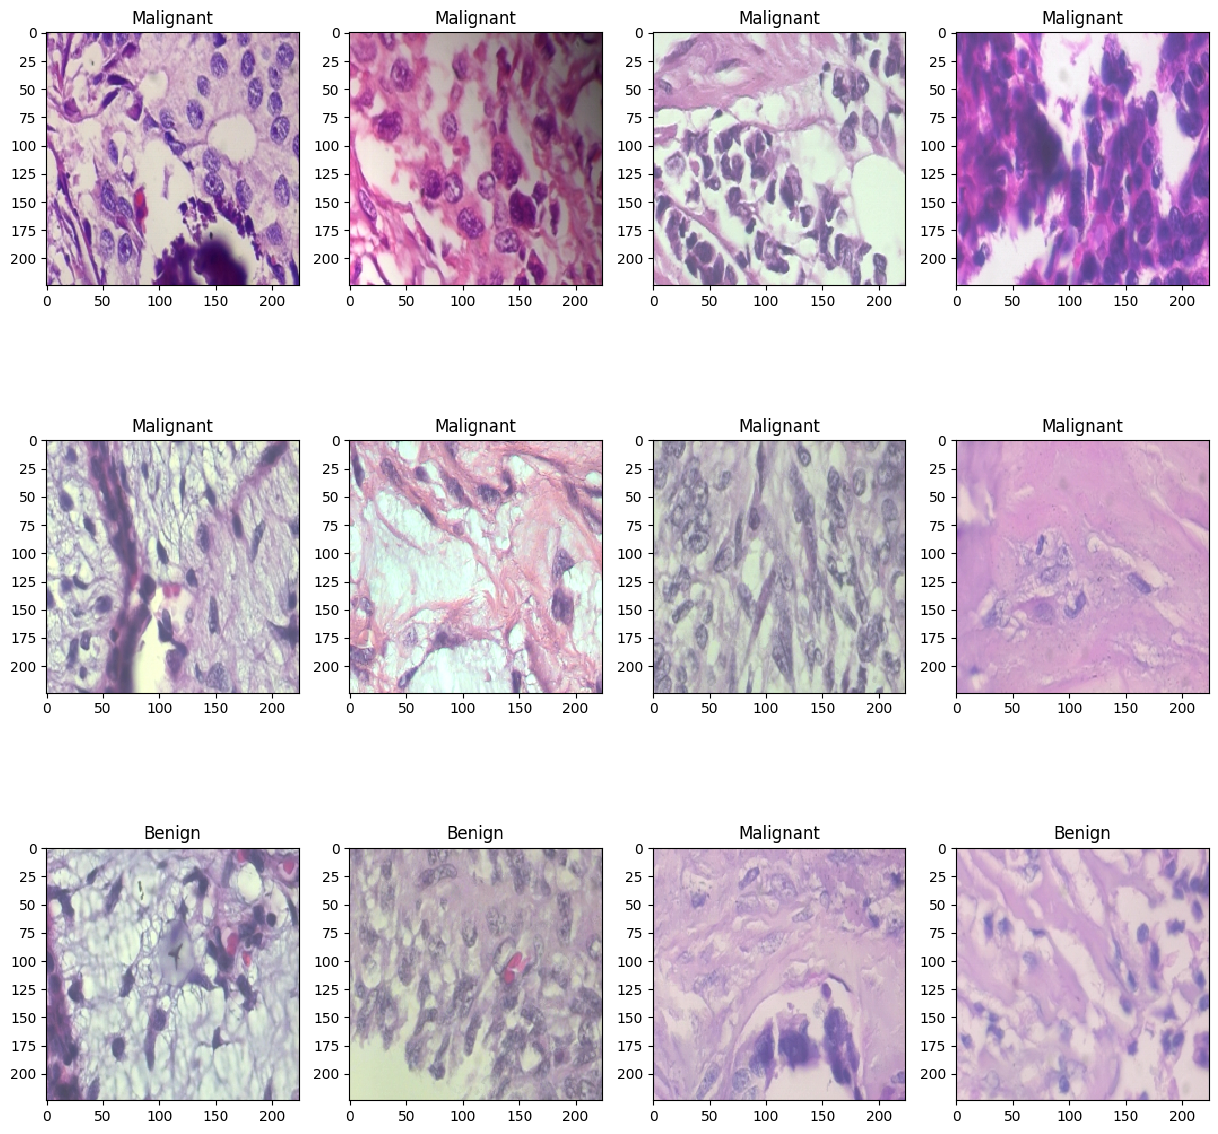

In [ ]:
benign_train = np.array(Dataset_loader('/content/gdrive/MyDrive/data (1)/train/benign',224))
malign_train = np.array(Dataset_loader('/content/gdrive/MyDrive/data (1)/train/malignant',224))
benign_test = np.array(Dataset_loader('/content/gdrive/MyDrive/data (1)/test/benign',224))
malign_test = np.array(Dataset_loader('/content/gdrive/MyDrive/data (1)/test/malignant',224))
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
#plt.show()
BATCH_SIZE = 16
# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))


    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )

    return model
K.clear_session()
gc.collect()

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)





model = build_model(resnet ,lr = 1e-4)
model.summary()

In [ ]:
from keras.callbacks import ModelCheckpoint
import numpy as np
from sklearn.metrics import accuracy_score

filepath = '/content/gdrive/MyDrive/data (1)'

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint]
)
model.load_weights("/content/gdrive/MyDrive/data (1)")

Y_val_pred = model.predict(x_val)
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

<ipython-input-12-11d9ca0ab8bd>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
58/57 [==============================] - ETA: -10s - loss: 0.5400 - accuracy: 0.7778
Epoch 1: val_accuracy improved from -inf to 0.73043, saving model to /content/gdrive/MyDrive/data (1)


57/57 [==============================] - 1258s 21s/step - loss: 0.5400 - accuracy: 0.7778 - val_loss: 84.9598 - val_accuracy: 0.7304
Epoch 2/20
58/57 [==============================] - ETA: -10s - loss: 0.4487 - accuracy: 0.8170
Epoch 2: val_accuracy did not improve from 0.73043
57/57 [==============================] - 1061s 18s/step - loss: 0.4487 - accuracy: 0.8170 - val_loss: 12.4133 - val_accuracy: 0.2522
Epoch 3/20
58/57 [==============================] - ETA: -11s - loss: 0.4447 - accuracy: 0.8192
Epoch 3: val_accuracy improved from 0.73043 to 0.77826, saving model to /content/gdrive/MyDrive/data (1)


57/57 [==============================] - 1247s 22s/step - loss: 0.4447 - accuracy: 0.8192 - val_loss: 0.5598 - val_accuracy: 0.7783
Epoch 4/20
58/57 [==============================] - ETA: -12s - loss: 0.4230 - accuracy: 0.8344
Epoch 4: val_accuracy improved from 0.77826 to 0.85652, saving model to /content/gdrive/MyDrive/data (1)


57/57 [==============================] - 1361s 24s/step - loss: 0.4230 - accuracy: 0.8344 - val_loss: 0.5077 - val_accuracy: 0.8565
Epoch 5/20
58/57 [==============================] - ETA: -11s - loss: 0.4388 - accuracy: 0.8181
Epoch 5: val_accuracy did not improve from 0.85652
57/57 [==============================] - 1126s 20s/step - loss: 0.4388 - accuracy: 0.8181 - val_loss: 1.3283 - val_accuracy: 0.7826
Epoch 6/20
58/57 [==============================] - ETA: -11s - loss: 0.4148 - accuracy: 0.8333
Epoch 6: val_accuracy improved from 0.85652 to 0.89130, saving model to /content/gdrive/MyDrive/data (1)


57/57 [==============================] - 1293s 23s/step - loss: 0.4148 - accuracy: 0.8333 - val_loss: 0.3634 - val_accuracy: 0.8913
Epoch 7/20
58/57 [==============================] - ETA: -10s - loss: 0.3691 - accuracy: 0.8519
Epoch 7: val_accuracy did not improve from 0.89130
57/57 [==============================] - 1092s 19s/step - loss: 0.3691 - accuracy: 0.8519 - val_loss: 0.4630 - val_accuracy: 0.7826
Epoch 8/20
58/57 [==============================] - ETA: -11s - loss: 0.3535 - accuracy: 0.8540
Epoch 8: val_accuracy did not improve from 0.89130
57/57 [==============================] - 1131s 20s/step - loss: 0.3535 - accuracy: 0.8540 - val_loss: 0.9426 - val_accuracy: 0.8130
Epoch 9/20
58/57 [==============================] - ETA: -11s - loss: 0.3441 - accuracy: 0.8551
Epoch 9: val_accuracy did not improve from 0.89130
57/57 [==============================] - 1136s 20s/step - loss: 0.3441 - accuracy: 0.8551 - val_loss: 0.9778 - val_accuracy: 0.7087
Epoch 10/20
58/57 [============